In [49]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
}))
options(timeout=100)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [20]:
set.seed(1234)
options(digits=2)
stats <- c()

In [21]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [22]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [23]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [24]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [25]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [26]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

### Load guide df

In [27]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting


## FeaturePlot singlet & doublet

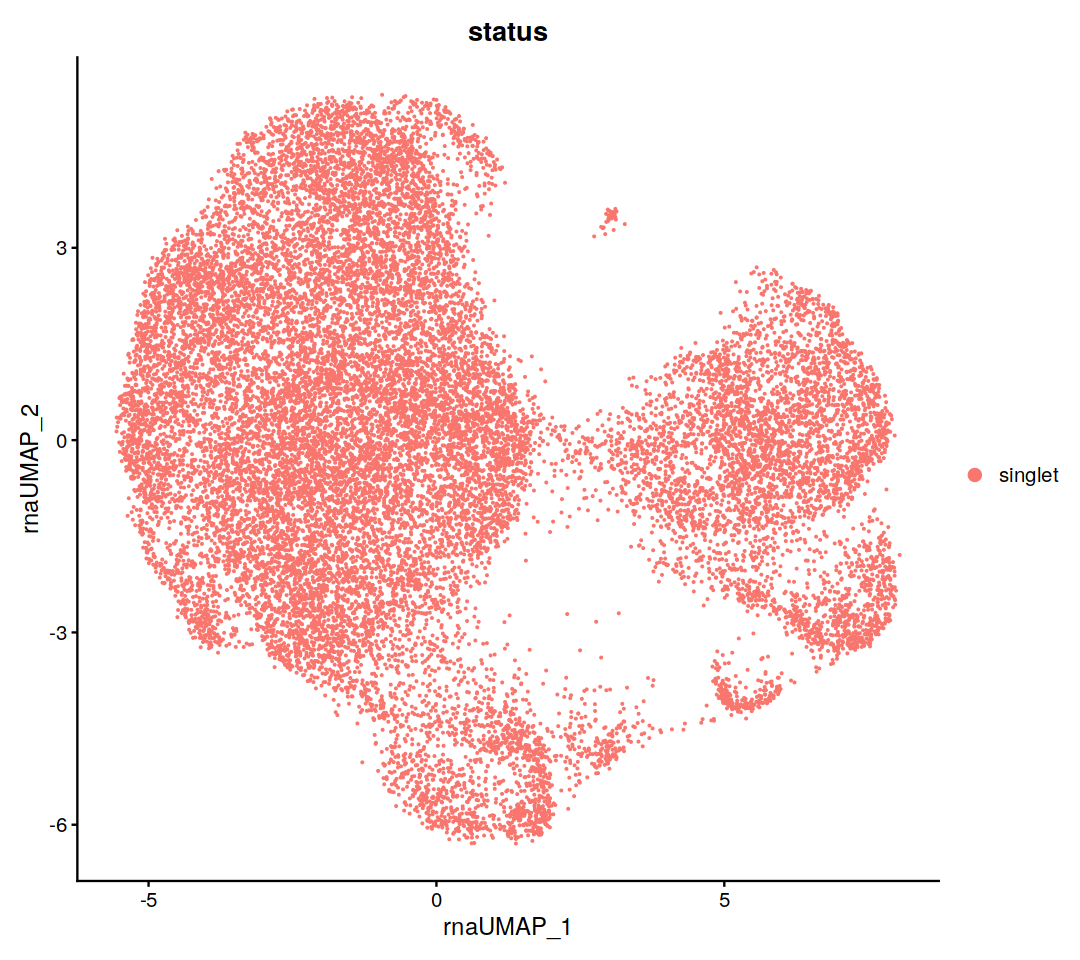

In [28]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seurat_combined, group.by='status')

# Differential expression

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [29]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [170]:
perturbed_cells_by_guide <- get_all_perturbed_cells_by_guide(seurat_libs) 
length(perturbed_cells_by_guide[[3]])

[1] 947

In [32]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a" "NTCE4-1b"

In [33]:
# This function is not necessary. Using mark_target_pos_neg()
# Mark cells that are positive for given guides as target_positive, all others as target_negative
mark_plasmid_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)    
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "plasmid_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "plasmid_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Plasmid+ =",n_gplus, "; Plasmid- =", n_gminus, "\n"))
    }
    
    seurat_obj
}


### Applications

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [34]:
select_targeting_guides = df_guide$class == 'targeting'
df_targeting  = df_guide[select_targeting_guides, ]
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents='target_negative'))

Guide+ = 20176 ; Guide- = 1188 


# <font color='yellow'> DE for all Targeting Guide pairs </font> 

In [78]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}

In [214]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
df_targeting = filter(df_guide, class=='targeting')
df_de = NULL
genes_to_skip = c("DE5", "CD55", "CSTB")
genes_to_skip = c()
lfc_threshold = 0.15

for(i in 1:nrow(df_targeting)){
    target = df_targeting[i, 'alias']
    if(target %in% genes_to_skip){
        cat(red("Skipping", target, "\n"))
        next
    }
    guides_on_plasmid = unlist(as.list(t(df_targeting[i, c('guide1', 'guide2')])))
    cat(blue(target,":"), paste(guides_on_plasmid, collapse=","),"\n")
    seurat_dummy <- mark_target_pos_neg(
        seurat_rna,
        perturbed_cells_by_guide, 
        guides_on_plasmid,
        print_counts = T,
        pos_label = "plasmid_positive",
        neg_label = "plasmid_negative"
    )
    if("plasmid_positive" %in% levels((Idents(seurat_dummy)))) {
        markers <- FindMarkers(
            verbose = F,
            object = seurat_dummy,
            slot = "data",
            ident.1 = 'plasmid_positive',
            ident.2 = 'plasmid_negative',
            test.use = "MAST",
            latent.vars = c("library", "donor"),
            logfc.threshold = lfc_threshold
        )
        # latent.vars = c('library') 
        if(nrow(markers)==0) {
            cat(Red("No DE genes", target,  "\n"))
        }
        markers$de_gene = rownames(markers)
        markers$target = target
        markers$plasmid = paste(guides_on_plasmid, collapse="_")
        rownames(markers) <- NULL
        df_de = rbind(df_de, markers)
    } else {
        cat(red("No cells found:"), paste(guides_on_plasmid, collapse=","),"\n")
    }
}

ANPEP : CD13-1a,CD13-1b 
CD13-1a   1055 
CD13-1b   1390 
Guide+ = 1390 ; Guide- = 19973 



 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   947 
CD55-1b   1298 
Guide+ = 1298 ; Guide- = 20065 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>--------

NT5E : CD73-1a,CD73-1b 
CD73-1a   889 
CD73-1b   1202 
Guide+ = 1202 ; Guide- = 20161 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>----

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   810 
FUBP1-1b   1060 
Guide+ = 1060 ; Guide- = 20303 



 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>---------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   990 
C15orf40-1b   1287 
Guide+ = 1287 ; Guide- = 20076 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>--------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   797 
MAFF-1b   1043 
Guide+ = 1043 ; Guide- = 20320 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>---------------

FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   718 
FTH1-1b   981 
Guide+ = 981 ; Guide- = 20382 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>---------------

FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   3247 
FTH1-2b   3247 
Guide+ = 3247 ; Guide- = 18116 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   1003 
PLIN3-1b   1298 
Guide+ = 1298 ; Guide- = 20065 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>---

PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   885 
PLIN3-2b   1194 
Guide+ = 1194 ; Guide- = 20169 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>--------------

TKT : TKT-1a,TKT-1b 
TKT-1a   765 
TKT-1b   1035 
Guide+ = 1035 ; Guide- = 20328 



 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>---------------

TKT : TKT-2a,TKT-2b 
TKT-2a   993 
TKT-2b   1347 
Guide+ = 1347 ; Guide- = 20016 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>---

LGALS3 : LGALS3-1a,LGALS3-1b 
LGALS3-1a   1059 
LGALS3-1b   1363 
Guide+ = 1363 ; Guide- = 20000 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>---

LGALS3 : LGALS3-2a,LGALS3-2b 
LGALS3-2a   949 
LGALS3-2b   1253 
Guide+ = 1253 ; Guide- = 20110 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>--

CSTB : CSTB-1a,CSTB-1b 
CSTB-1a   1074 
CSTB-1b   1420 
Guide+ = 1420 ; Guide- = 19943 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

CSTB : CSTB-2a,CSTB-2b 
CSTB-2a   1098 
CSTB-2b   1403 
Guide+ = 1403 ; Guide- = 19960 



 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>--------------

CTSB : CTSB-1a,CTSB-1b 
CTSB-1a   1184 
CTSB-1b   1477 
Guide+ = 1477 ; Guide- = 19886 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>-------------

CTSB : CTSB-2a,CTSB-2b 
CTSB-2a   1037 
CTSB-2b   1281 
Guide+ = 1281 ; Guide- = 20082 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>------------

KLF6 : KLF6-1a,KLF6-1b 
KLF6-1a   1035 
KLF6-1b   1337 
Guide+ = 1337 ; Guide- = 20026 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>----------

KLF6 : KLF6-2a,KLF6-2b 
KLF6-2a   1103 
KLF6-2b   1388 
Guide+ = 1388 ; Guide- = 19975 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>---------------

DE1 : DE1-1a,DE1-1b 
DE1-1a   968 
DE1-1b   1255 
Guide+ = 1255 ; Guide- = 20108 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>------

DE1 : DE1-2a,DE1-2b 
DE1-2a   1086 
DE1-2b   1470 
Guide+ = 1470 ; Guide- = 19893 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>------------

DE2 : DE2-1a,DE2-1b 
DE2-1a   0 
DE2-1b   0 
Guide+ = 0 ; Guide- = 21363 
No cells found: DE2-1a,DE2-1b 
DE2 : DE2-2a,DE2-2b 
DE2-2a   1076 
DE2-2b   1420 
Guide+ = 1420 ; Guide- = 19943 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [========================>--

DE3 : DE3-1a,DE3-1b 
DE3-1a   1138 
DE3-1b   1472 
Guide+ = 1472 ; Guide- = 19891 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>---------

DE3 : DE3-2a,DE3-2b 
DE3-2a   1094 
DE3-2b   1459 
Guide+ = 1459 ; Guide- = 19904 



 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>--------------

DE4 : DE4-1a,DE4-1b 
DE4-1a   1825 
DE4-1b   1911 
Guide+ = 1911 ; Guide- = 19452 



 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

DE4 : DE4-2a,DE4-2b 
DE4-2a   934 
DE4-2b   1189 
Guide+ = 1189 ; Guide- = 20174 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

DE5 : DE5-1a,DE5-1b 
DE5-1a   1163 
DE5-1b   1520 
Guide+ = 1520 ; Guide- = 19843 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>--

DE5 : DE5-2a,DE5-2b 
DE5-2a   1209 
DE5-2b   1533 
Guide+ = 1533 ; Guide- = 19830 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [====================>------

DE6 : DE6-1a,DE6-1b 
DE6-1a   1053 
DE6-1b   1394 
Guide+ = 1394 ; Guide- = 19969 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>---

DE6 : DE6-2a,DE6-2b 
DE6-2a   2079 
DE6-2b   2090 
Guide+ = 2090 ; Guide- = 19274 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>-----------

DE7 : DE7-1a,DE7-1b 
DE7-1a   1197 
DE7-1b   1530 
Guide+ = 1530 ; Guide- = 19833 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>-----

DE7 : DE7-2a,DE7-2b 
DE7-2a   994 
DE7-2b   1286 
Guide+ = 1286 ; Guide- = 20077 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>---

DE8 : DE8-1a,DE8-1b 
DE8-1a   1147 
DE8-1b   1580 
Guide+ = 1580 ; Guide- = 19783 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>------

DE8 : DE8-2a,DE8-2b 
DE8-2a   1326 
DE8-2b   1760 
Guide+ = 1760 ; Guide- = 19603 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>-------------

DE9 : DE9-1a,DE9-1b 
DE9-1a   1122 
DE9-1b   1542 
Guide+ = 1542 ; Guide- = 19821 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>---------

DE9 : DE9-2a,DE9-2b 
DE9-2a   0 
DE9-2b   0 
Guide+ = 0 ; Guide- = 21363 
No cells found: DE9-2a,DE9-2b 
DE10 : DE10-1a,DE10-1b 
DE10-1a   874 
DE10-1b   1135 
Guide+ = 1135 ; Guide- = 20228 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>----------

DE10 : DE10-2a,DE10-2b 
DE10-2a   900 
DE10-2b   1210 
Guide+ = 1210 ; Guide- = 20153 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>---

DE11 : DE11-1a,DE11-1b 
DE11-1a   1110 
DE11-1b   1400 
Guide+ = 1400 ; Guide- = 19963 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>---------

DE11 : DE11-2a,DE11-2b 
DE11-2a   1005 
DE11-2b   1301 
Guide+ = 1301 ; Guide- = 20062 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [====================>------

DE12 : DE12-1a,DE12-1b 
DE12-1a   1003 
DE12-1b   1288 
Guide+ = 1288 ; Guide- = 20075 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>----------

DE12 : DE12-2a,DE12-2b 
DE12-2a   941 
DE12-2b   1277 
Guide+ = 1277 ; Guide- = 20086 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>-------

DE13 : DE13-1a,DE13-1b 
DE13-1a   935 
DE13-1b   968 
Guide+ = 968 ; Guide- = 20395 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>--------------

DE13 : DE13-2a,DE13-2b 
DE13-2a   791 
DE13-2b   1050 
Guide+ = 1050 ; Guide- = 20313 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>--------

DE14 : DE14-1a,DE14-1b 
DE14-1a   1130 
DE14-1b   1469 
Guide+ = 1469 ; Guide- = 19894 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>--------

DE14 : DE14-2a,DE14-2b 
DE14-2a   1009 
DE14-2b   1274 
Guide+ = 1274 ; Guide- = 20089 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>---------

DE15 : DE15-1a,DE15-1b 
DE15-1a   945 
DE15-1b   1235 
Guide+ = 1235 ; Guide- = 20128 



 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>----------------

DE15 : DE15-2a,DE15-2b 
DE15-2a   1199 
DE15-2b   1588 
Guide+ = 1588 ; Guide- = 19775 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>------------

DE16 : DE16-1a,DE16-1b 
DE16-1a   850 
DE16-1b   1209 
Guide+ = 1209 ; Guide- = 20154 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>--------------

DE16 : DE16-2a,DE16-2b 
DE16-2a   0 
DE16-2b   1051 
Guide+ = 1051 ; Guide- = 20312 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>--------

DE17 : DE17-1a,DE17-1b 
DE17-1a   984 
DE17-1b   1289 
Guide+ = 1289 ; Guide- = 20074 



 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>----------------

DE17 : DE17-2a,DE17-2b 
DE17-2a   954 
DE17-2b   1290 
Guide+ = 1290 ; Guide- = 20073 



 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>----

Write to file

In [215]:
lfc = gsub("\\.", "_", lfc_threshold)
de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_", lfc, "_UNFILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

### Filter out spurious hits

In [216]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
funky_de_genes = c("HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A")
df_de = filter(df_de, !(de_gene  %in% funky_de_genes))

de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_", lfc, "_FILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

# Inpect DE results

In [217]:
de_f_name
df_de = read.table(de_f_name, sep="\t",  header = T)

[1] "/home/vsevim/prj/1012-ckd/S1/analysis/secondary//integrated/DE_outputs/DE_genes_by_plasmid_LFC_0_15_FILTERED.tsv"

Print top high-confidence hits

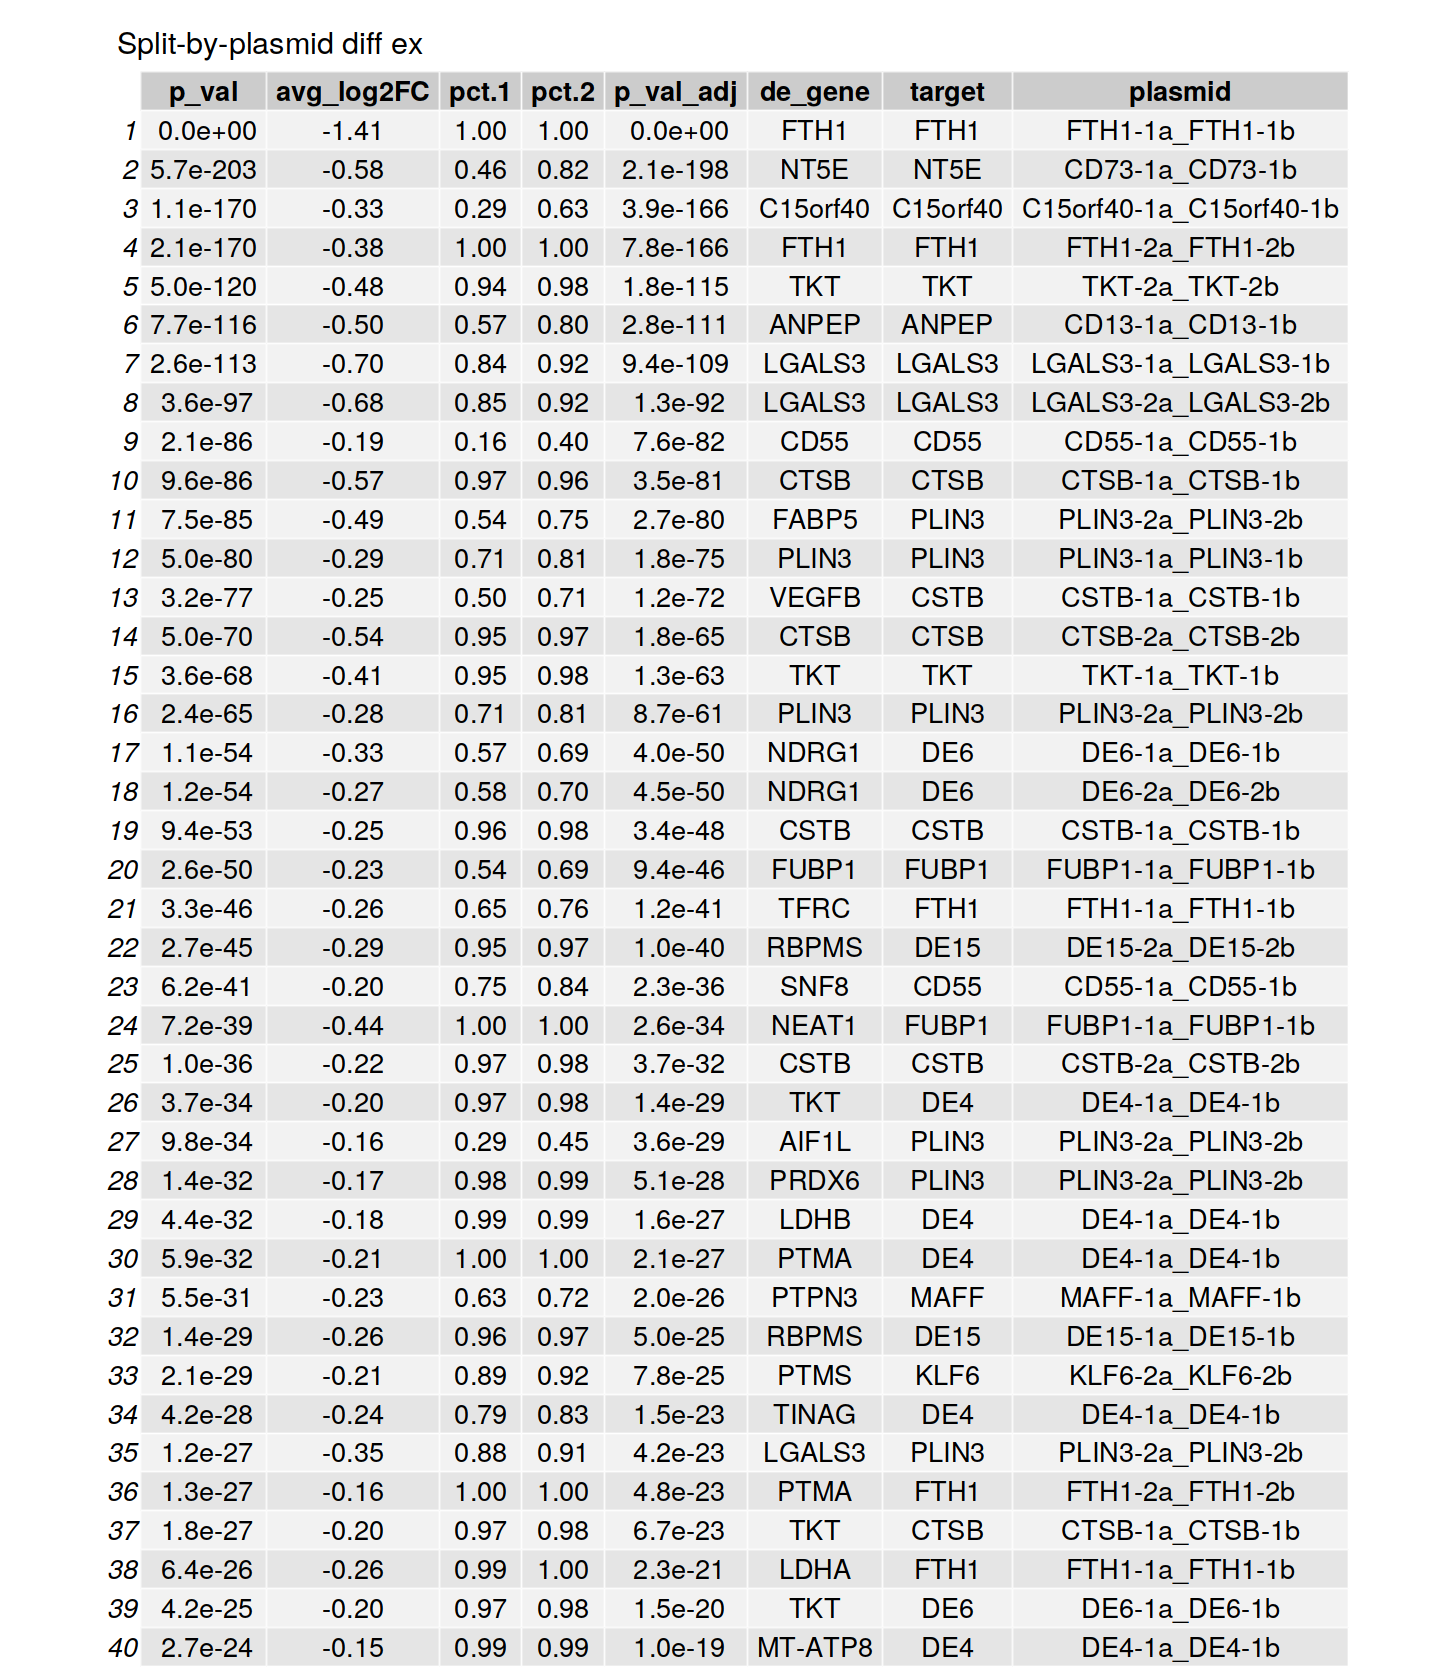

In [223]:
df_top_hits <- df_de %>% filter(avg_log2FC < 0) %>% arrange(p_val_adj) %>% head(40)

tb <- ggtexttable(df_top_hits, theme= ttheme(base_size = 16)) %>% tab_add_title(text = "Split-by-plasmid diff ex", face = "plain", size = 18)
options(repr.plot.width=12, repr.plot.height=14)
print(tb)

# Visualize Knockdowns

## TSS controls

ANPEP : CD13-1a,CD13-1b 
CD13-1a   1055 
CD13-1b   1390 
Guide+ = 1390 ; Guide- = 19973 
CD55 : CD55-1a,CD55-1b 
CD55-1a   947 
CD55-1b   1298 
Guide+ = 1298 ; Guide- = 20065 
NT5E : CD73-1a,CD73-1b 
CD73-1a   889 
CD73-1b   1202 
Guide+ = 1202 ; Guide- = 20161 
FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   810 
FUBP1-1b   1060 
Guide+ = 1060 ; Guide- = 20303 
C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   990 
C15orf40-1b   1287 
Guide+ = 1287 ; Guide- = 20076 
MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   797 
MAFF-1b   1043 
Guide+ = 1043 ; Guide- = 20320 


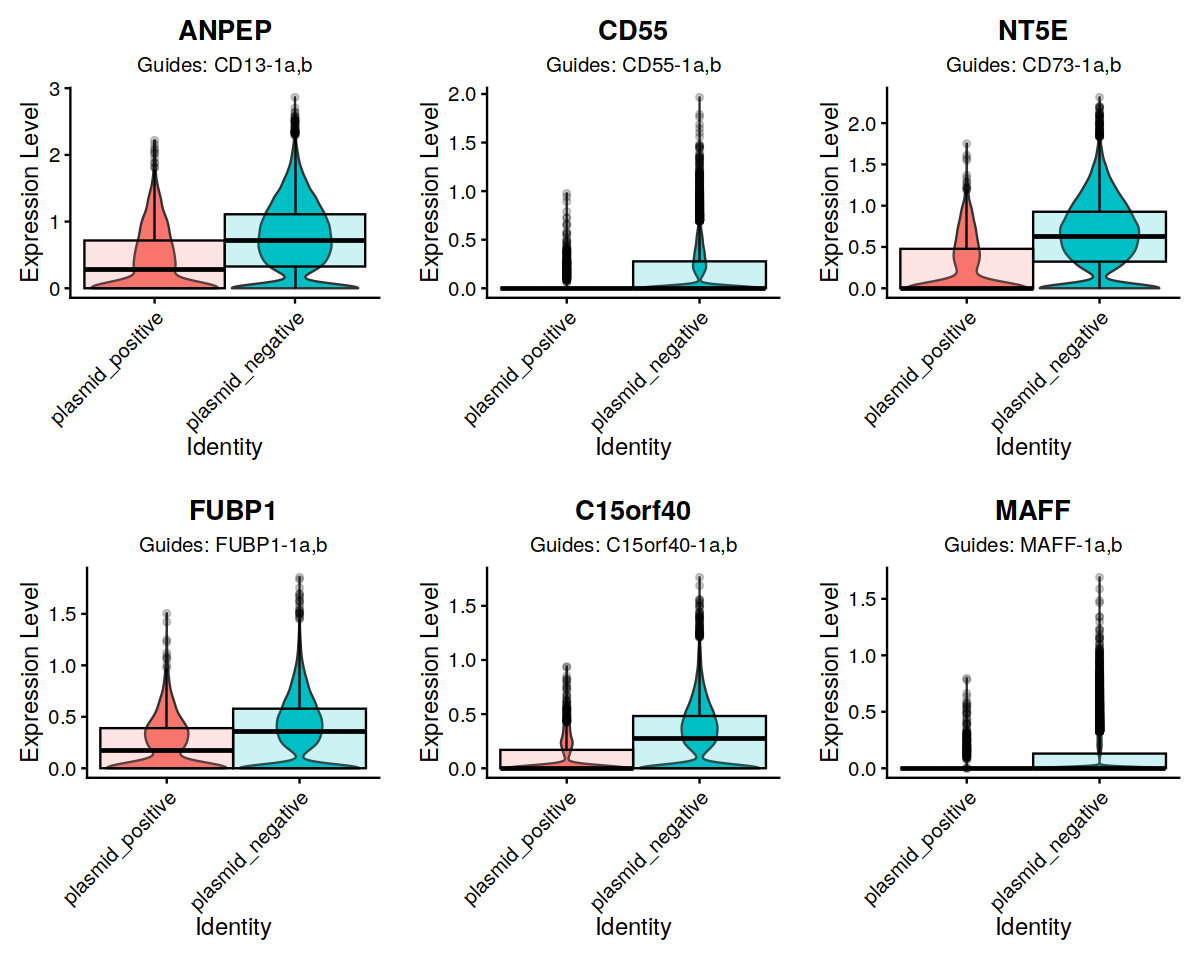

In [187]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
df_tss = filter(df_guide, subclass=='tss')
plots = vlnplot_for_plasmids(seurat_rna, df_tss, perturbed_cells_by_guide)
options(repr.plot.width=10, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## DE controls

FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   718 
FTH1-1b   981 
Guide+ = 981 ; Guide- = 20382 
FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   3247 
FTH1-2b   3247 
Guide+ = 3247 ; Guide- = 18116 
PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   1003 
PLIN3-1b   1298 
Guide+ = 1298 ; Guide- = 20065 
PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   885 
PLIN3-2b   1194 
Guide+ = 1194 ; Guide- = 20169 
TKT : TKT-1a,TKT-1b 
TKT-1a   765 
TKT-1b   1035 
Guide+ = 1035 ; Guide- = 20328 
TKT : TKT-2a,TKT-2b 
TKT-2a   993 
TKT-2b   1347 
Guide+ = 1347 ; Guide- = 20016 
LGALS3 : LGALS3-1a,LGALS3-1b 
LGALS3-1a   1059 
LGALS3-1b   1363 
Guide+ = 1363 ; Guide- = 20000 
LGALS3 : LGALS3-2a,LGALS3-2b 
LGALS3-2a   949 
LGALS3-2b   1253 
Guide+ = 1253 ; Guide- = 20110 
CSTB : CSTB-1a,CSTB-1b 
CSTB-1a   1074 
CSTB-1b   1420 
Guide+ = 1420 ; Guide- = 19943 
CSTB : CSTB-2a,CSTB-2b 
CSTB-2a   1098 
CSTB-2b   1403 
Guide+ = 1403 ; Guide- = 19960 
CTSB : CTSB-1a,CTSB-1b 
CTSB-1a   1184 
CTSB-1b   1477 
Guide+ = 1477 ; Guide- = 19886 
CTSB : CTSB-2a,CTSB

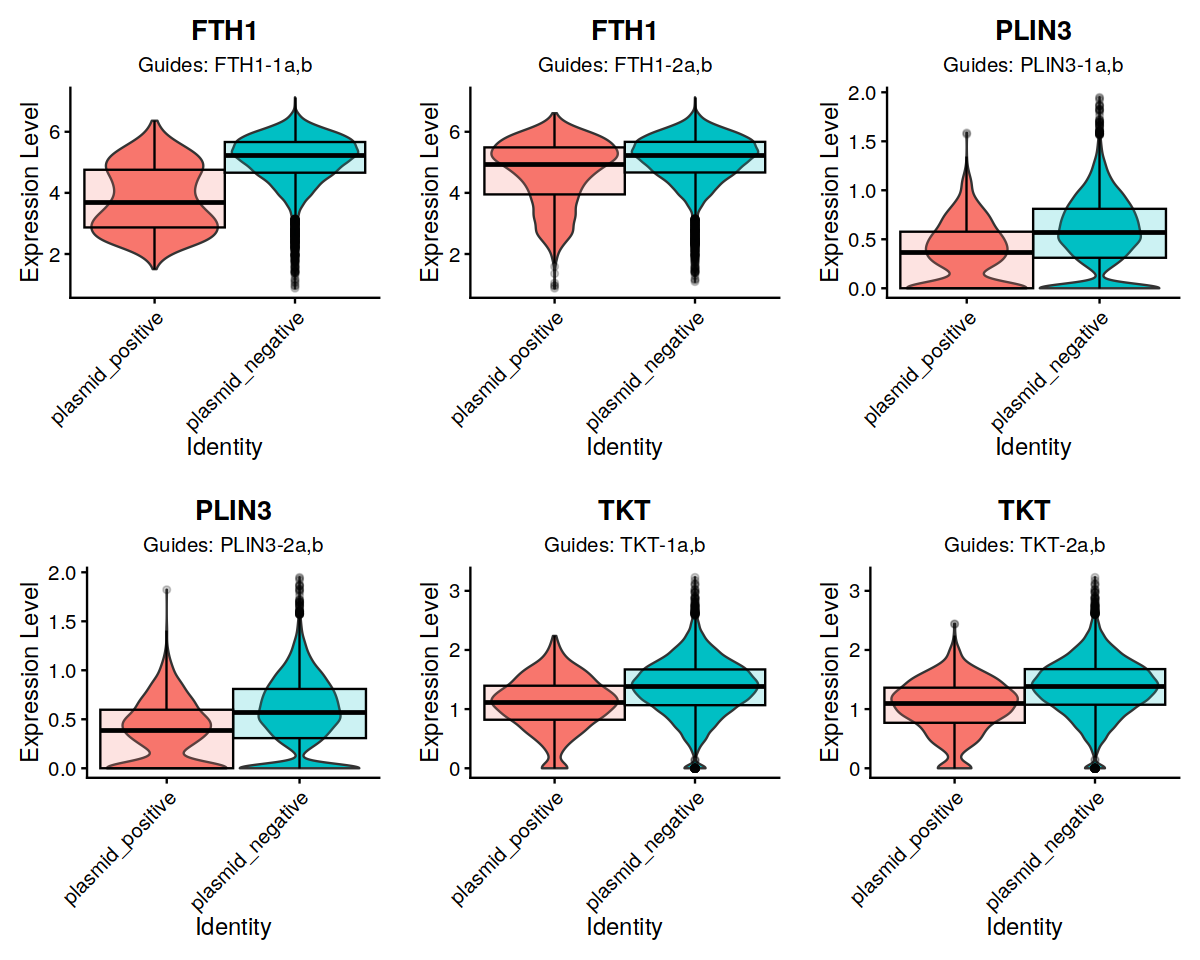

$`1`

$`2`

$`3`

attr(,"class")
[1] "list"      "ggarrange"

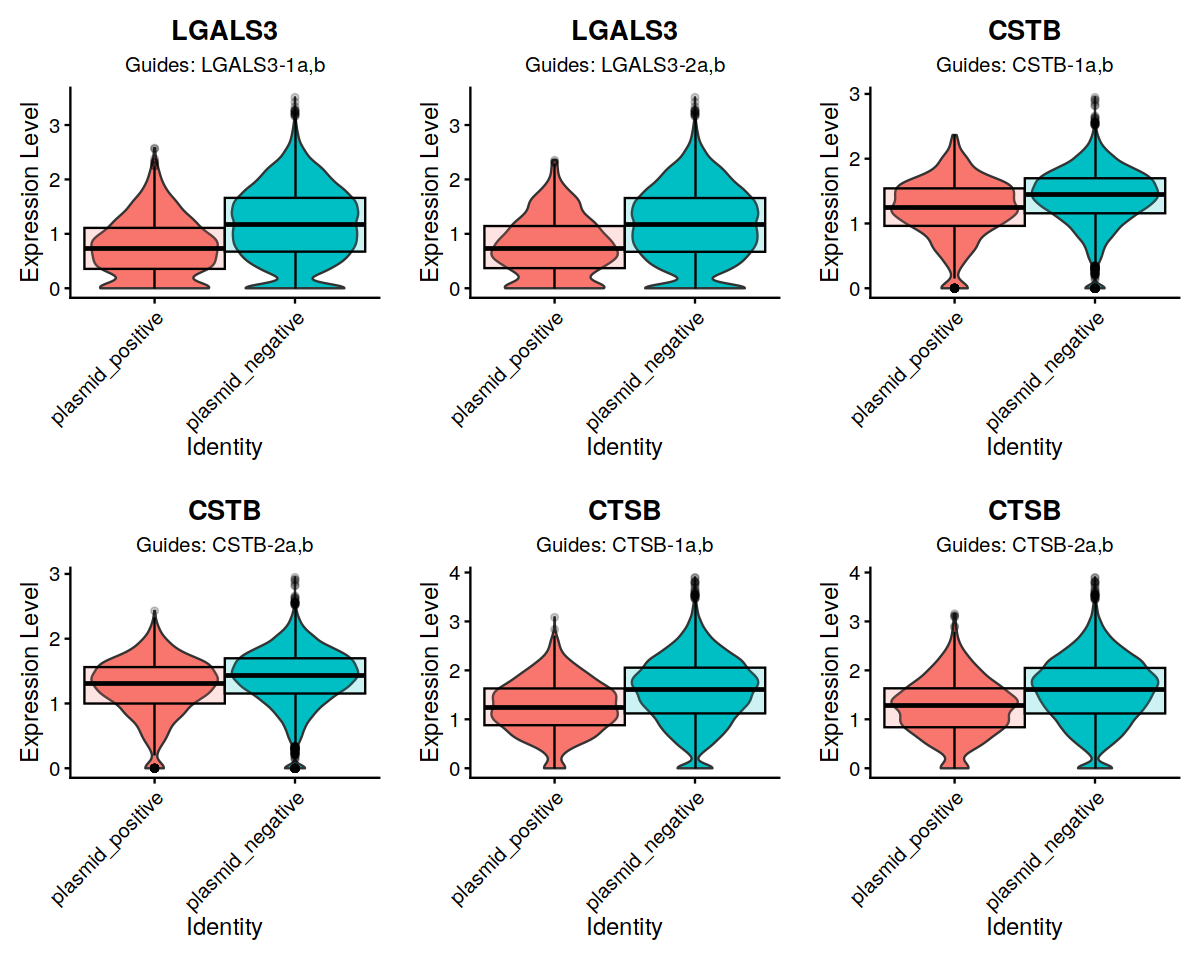

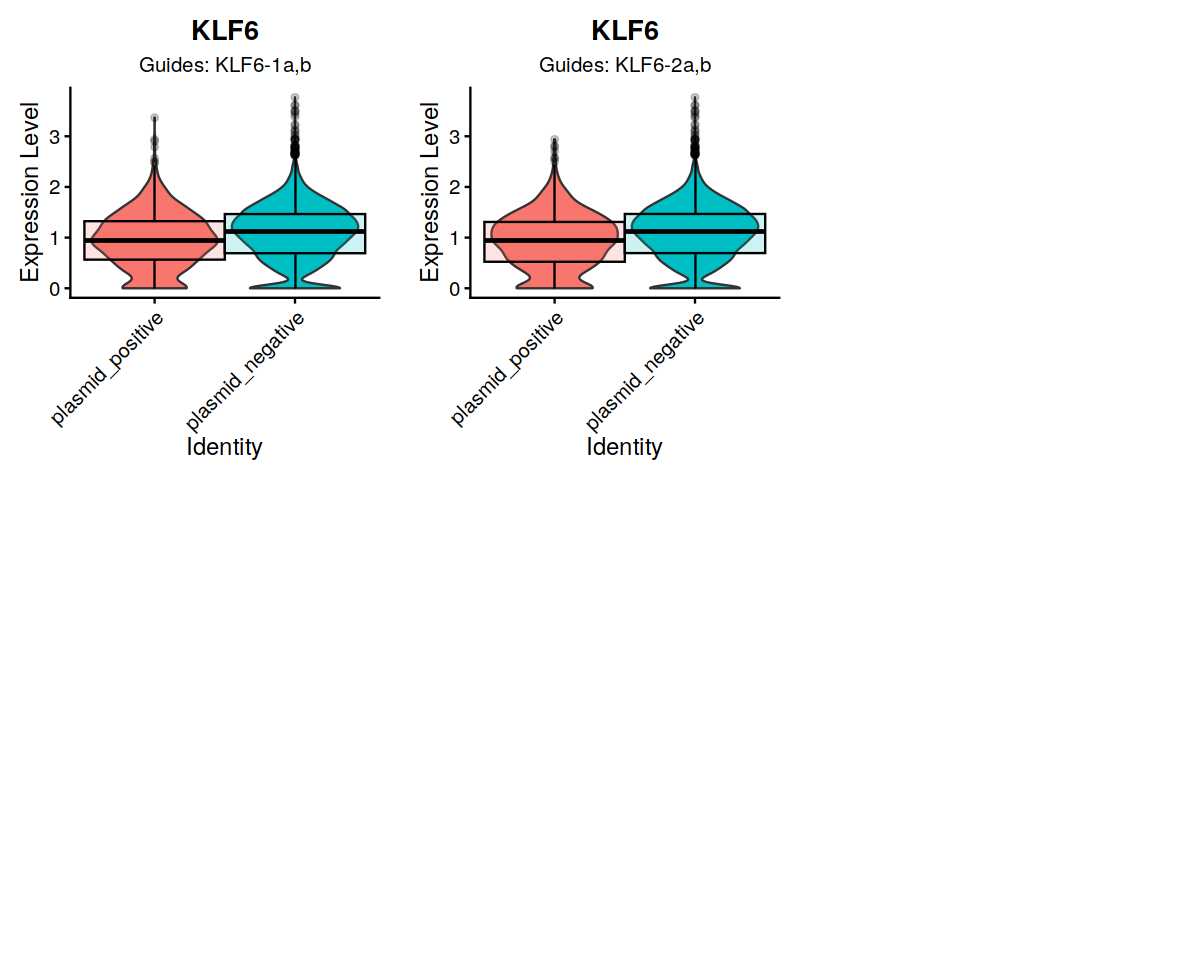

In [188]:
df_de_control = filter(df_guide, subclass=='de_control')
plots = vlnplot_for_plasmids(seurat_rna, df_de_control, perturbed_cells_by_guide)
options(repr.plot.width=10, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## CKD DE 

[1] "DE6-1a" "DE6-1b"
DE6-1a   1053 
DE6-1b   1394 
Guide+ = 1394 ; Guide- = 19969 
[1] "DE6-2a" "DE6-2b"
DE6-2a   2079 
DE6-2b   2090 
Guide+ = 2090 ; Guide- = 19274 


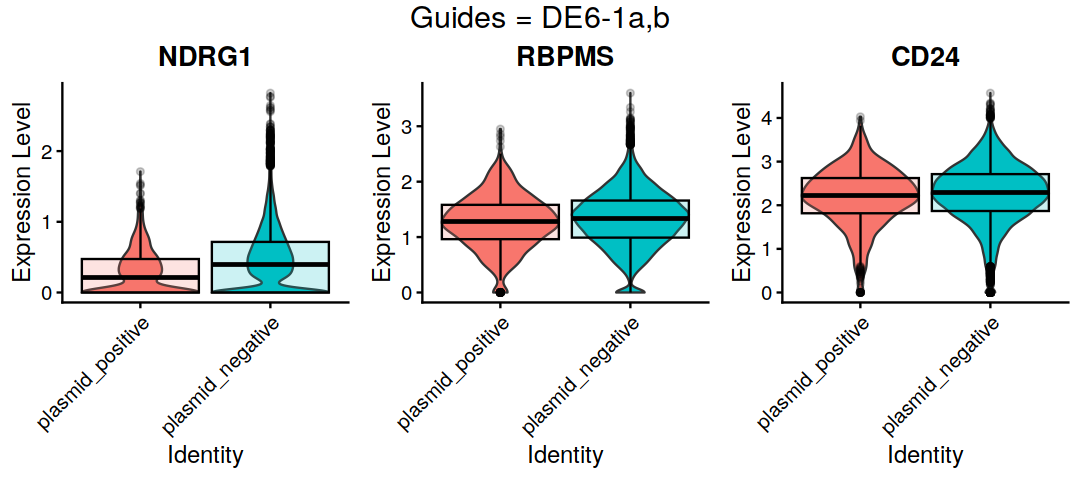

[1] "DE15-1a" "DE15-1b"
DE15-1a   945 
DE15-1b   1235 
Guide+ = 1235 ; Guide- = 20128 


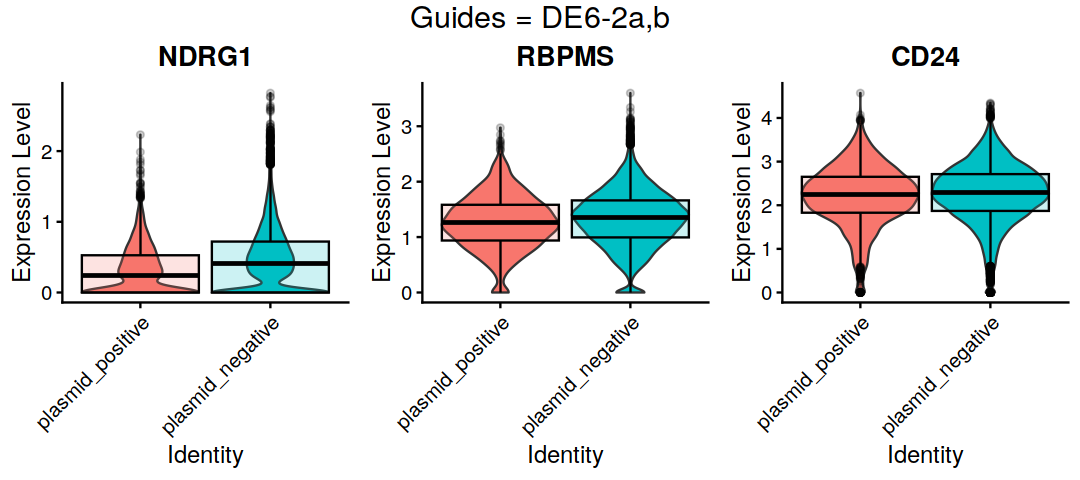

[1] "DE15-2a" "DE15-2b"
DE15-2a   1199 
DE15-2b   1588 
Guide+ = 1588 ; Guide- = 19775 


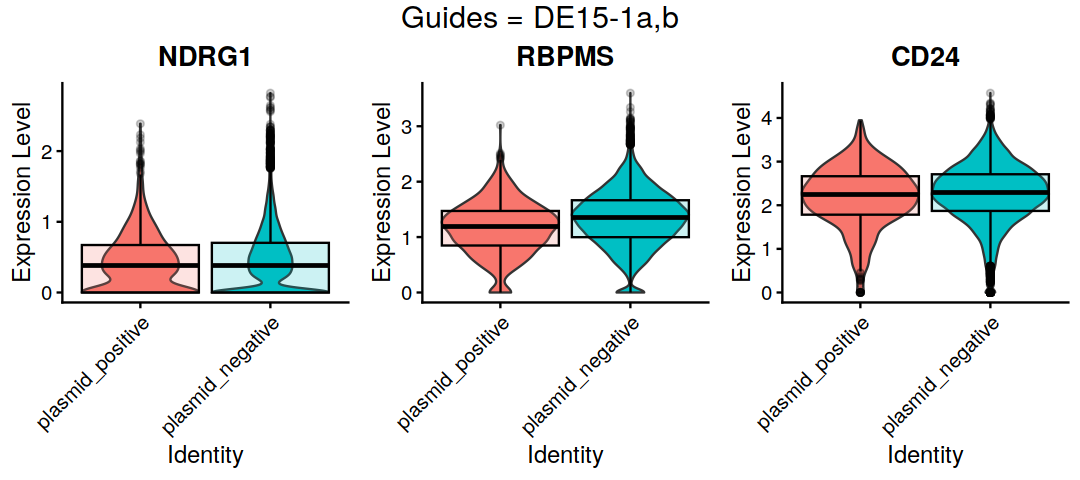

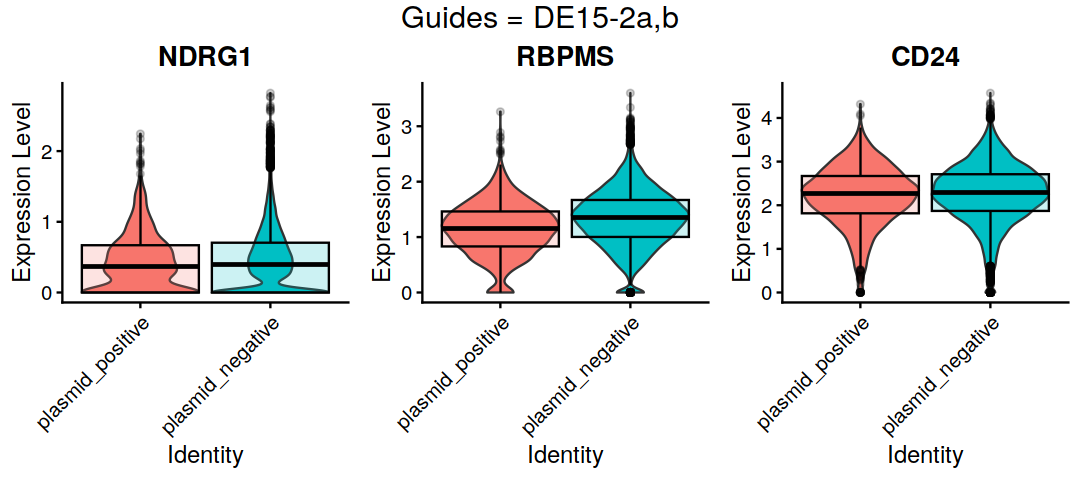

In [189]:
guide_pairs = list(c("DE6-1a", "DE6-1b"), c("DE6-2a", "DE6-2b"), c("DE15-1a", "DE15-1b"), c("DE15-2a", "DE15-2b"))
regulated_genes = c("NDRG1", "RBPMS", "CD24")

for(i in seq_along(guide_pairs)) {        
    guides_on_plasmid = unlist(guide_pairs[i])
    print(guides_on_plasmid)

    seurat_dummy <- mark_target_pos_neg(
        seurat_rna,
        perturbed_cells_by_guide, 
        guides_on_plasmid,
        print_counts = T,
        pos_label = "plasmid_positive",
        neg_label = "plasmid_negative"
    )

    options(repr.plot.width=9, repr.plot.height=4)
    plots <- VlnPlot(
            object = seurat_dummy,
            features = regulated_genes, 
            idents = NULL, 
            pt.size = 0, 
            sort = F, 
            ncol = 3,  
            combine = F  
        )

    for(i in 1:length(plots)) {
        plots[[i]] <- plots[[i]] + 
        NoLegend() +
        geom_boxplot(width=2, color="black", alpha=0.2) +
        theme(legend.position = 'none')

    }
    title = paste0("Guides = ", guides_on_plasmid[[1]][1], ",b")
    plt1 <- ggarrange(plotlist=plots, ncol=3, nrow = 1) 
    plt1 <- annotate_figure(plt1, top = text_grob(title, color = "black", size = 18))  

    print(plt1) 
}



# Debug

In [190]:
length(unlist(perturbed_cells_by_guide['DE15-1a']))

[1] 945

In [191]:
sum(seurat_libs[[1]][['sgRNA']]@counts['DE15-1a', ]>=14) +
sum(seurat_libs[[2]][['sgRNA']]@counts['DE15-1a', ]>=10) +
sum(seurat_libs[[3]][['sgRNA']]@counts['DE15-1a', ]>=38) +
sum(seurat_libs[[4]][['sgRNA']]@counts['DE15-1a', ]>=34)

[1] 945

In [193]:
head(tail(df_thresholds,35),3)

,guide,Lib_1,Lib_2,Lib_3,Lib_4
,<chr>,<int>,<int>,<int>,<int>
89,DE14-2a,19,13,60,34
90,DE14-2b,23,11,51,19
91,DE15-1a,14,10,38,34
